In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from natsort import natsorted
import seaborn as sns
from collections import Counter
import random

In [2]:
# Load the CSV file without using the first row as header (header=None)
df = pd.read_csv('Moral Poll Responses - Responses_final_version.csv', header=None)

# Define new, meaningful column names for the dataset
new_column_names = ['Timestamp', 'participant_ID', 'Consent', 'question_ID', 'Moral Judgment', 'Age', 'Gender', 'Nationality', 'Group']

# Assign these new column names to the DataFrame
df.columns = new_column_names

# Display the first rows of the DataFrame with the updated column names
print(df.head())

# Step 1: Identify participants who answered exactly 30 questions (complete responders)
counts = df['participant_ID'].value_counts()
valid_participants = counts[counts == 30].index

# Step 2: Filter the DataFrame to keep only data from these valid participants
df2 = df[df['participant_ID'].isin(valid_participants)]

# Step 3: Print the number of participants with exactly 30 responses
print(f"Number of participants with exactly 30 responses: {len(valid_participants)}")

# Remove duplicate rows to keep only one record per participant (for demographic data)
df_unique = df2.drop_duplicates(subset='participant_ID')

# Count the number of participants per nationality
nationality_counts = df_unique['Nationality'].value_counts()

# Calculate the mean and standard deviation of participants' ages
mean_age = df_unique['Age'].mean()
std_age = df_unique['Age'].std()

# Print nationality counts and age statistics
print("Number of participants per nationality:")
print(nationality_counts)
print(f"\nMean age: {mean_age:.2f}")
print(f"Age standard deviation: {std_age:.2f}")

# Calculate the proportion of each gender within the filtered participants (divided by 30 questions per participant)
gender_counts = df2['Gender'].value_counts() / 30
print("\nProportion of responses by gender:")
print(gender_counts)


             Timestamp participant_ID  Consent question_ID Moral Judgment  \
0  23/04/2025 19:39:12     P-09iohfyd     True       D_1_1        Neutral   
1  29/04/2025 22:02:34     P-4spo87q4     True       D_1_1        Neutral   
2  29/04/2025 22:58:39     P-57supgbn     True       D_1_1        Support   
3  24/04/2025 19:08:01     P-5v7x64tc     True       D_1_1          Blame   
4  24/04/2025 19:59:05     P-8r0lc177     True       D_1_1        Neutral   

   Age  Gender Nationality Group  
0   24    Male      French     A  
1   24  Female  Française      A  
2   24  Female  Française      A  
3   24  Female      French     A  
4   24    Male      France     A  
Number of participants with exactly 30 responses: 94
Number of participants per nationality:
Spanish           20
French            12
Spain              8
Française          7
Française          5
Italian            4
France             4
française          2
FRANCAISE          2
French             2
Spanish            2
Rus

# Visualization of Moral Judgment Distributions Across Scenarios and Actions

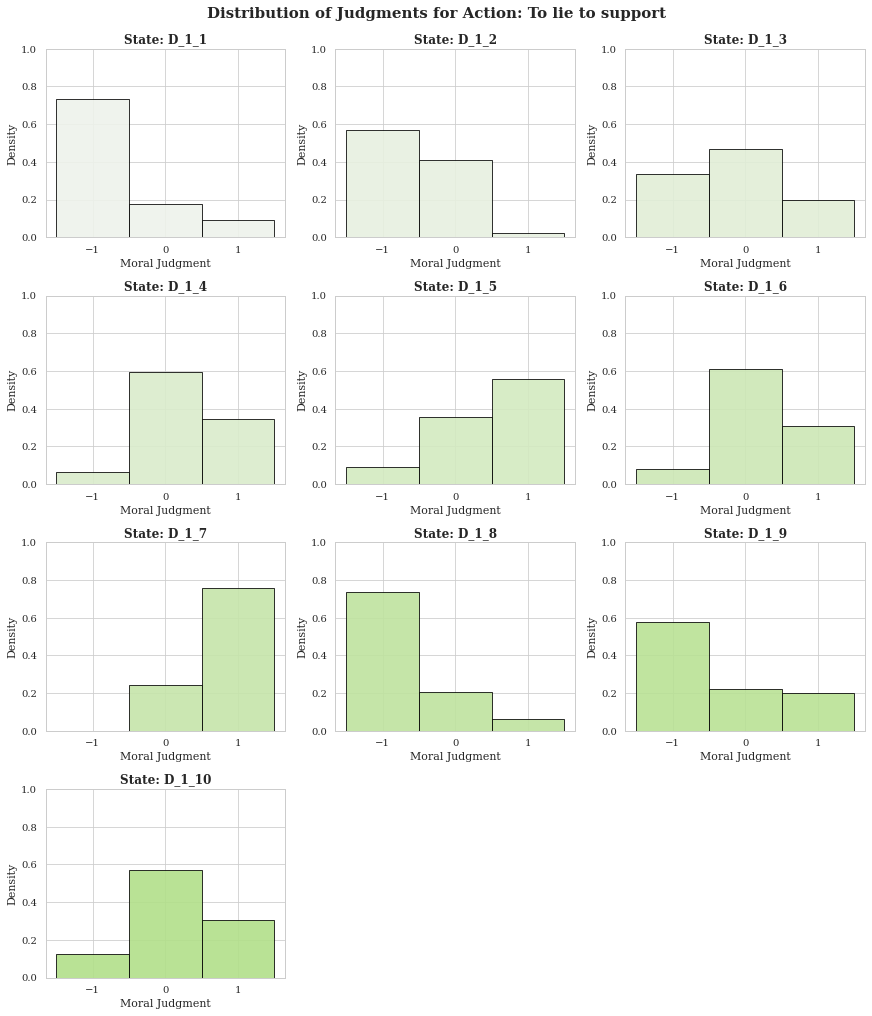

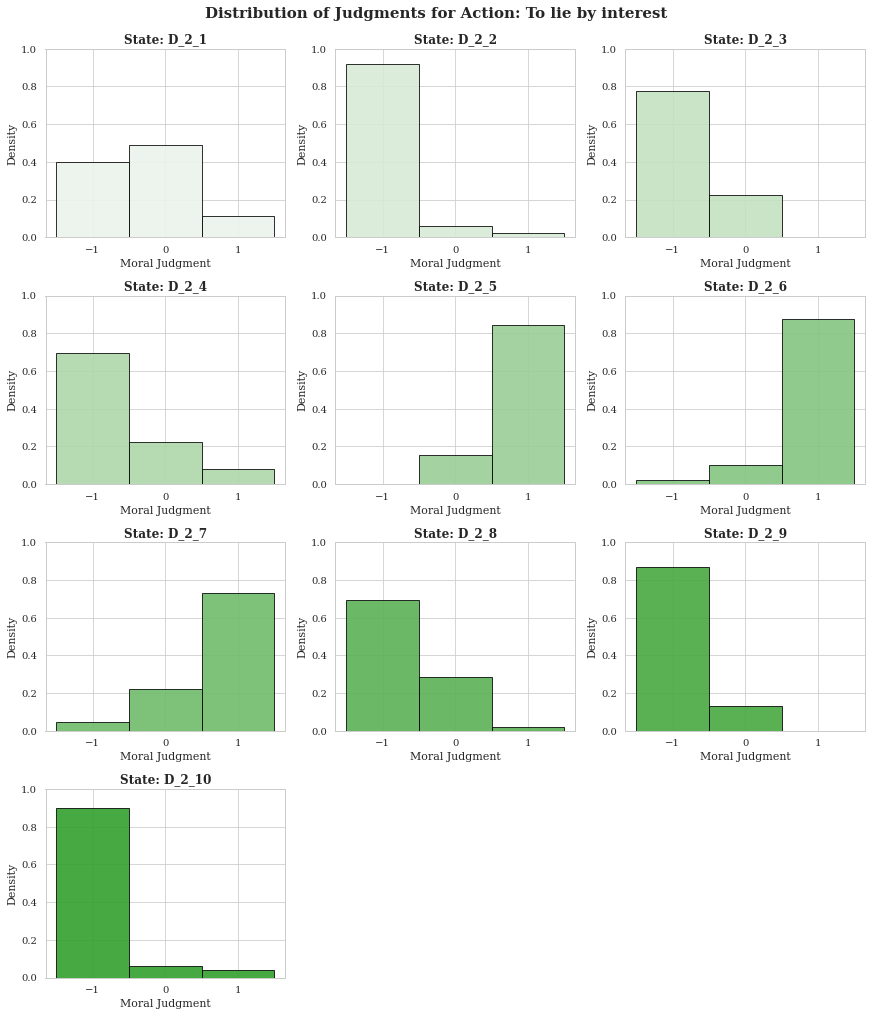

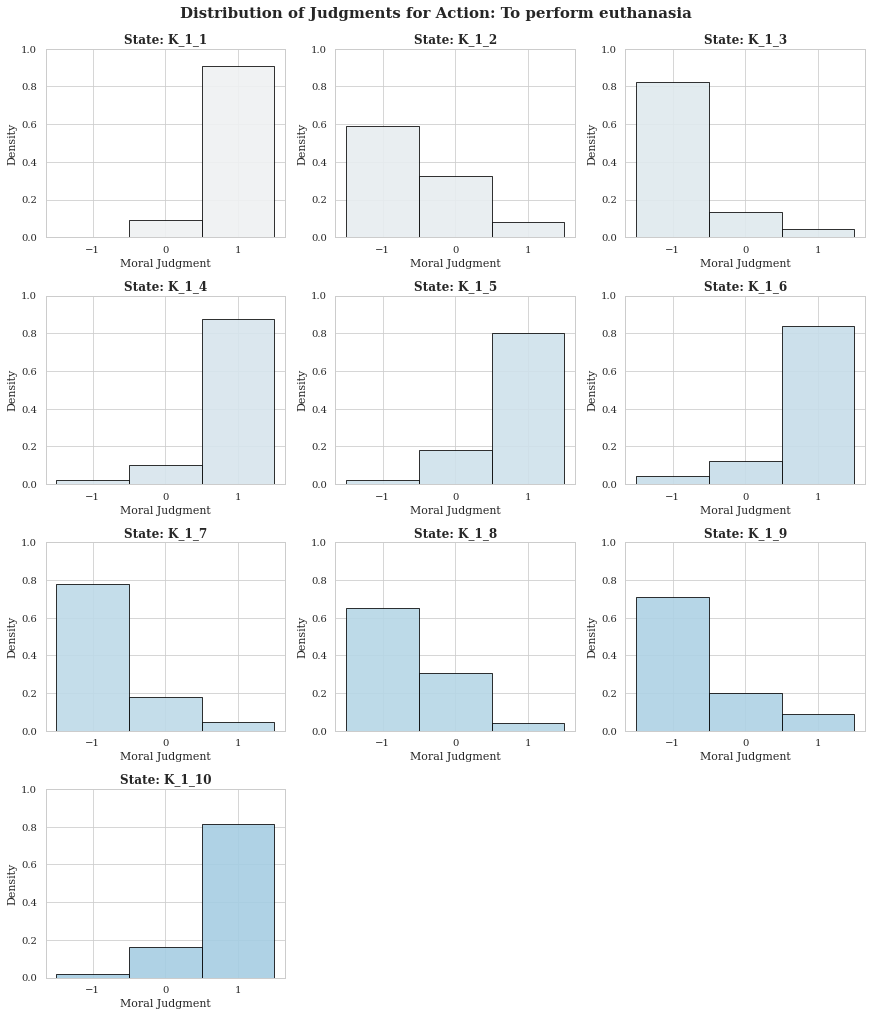

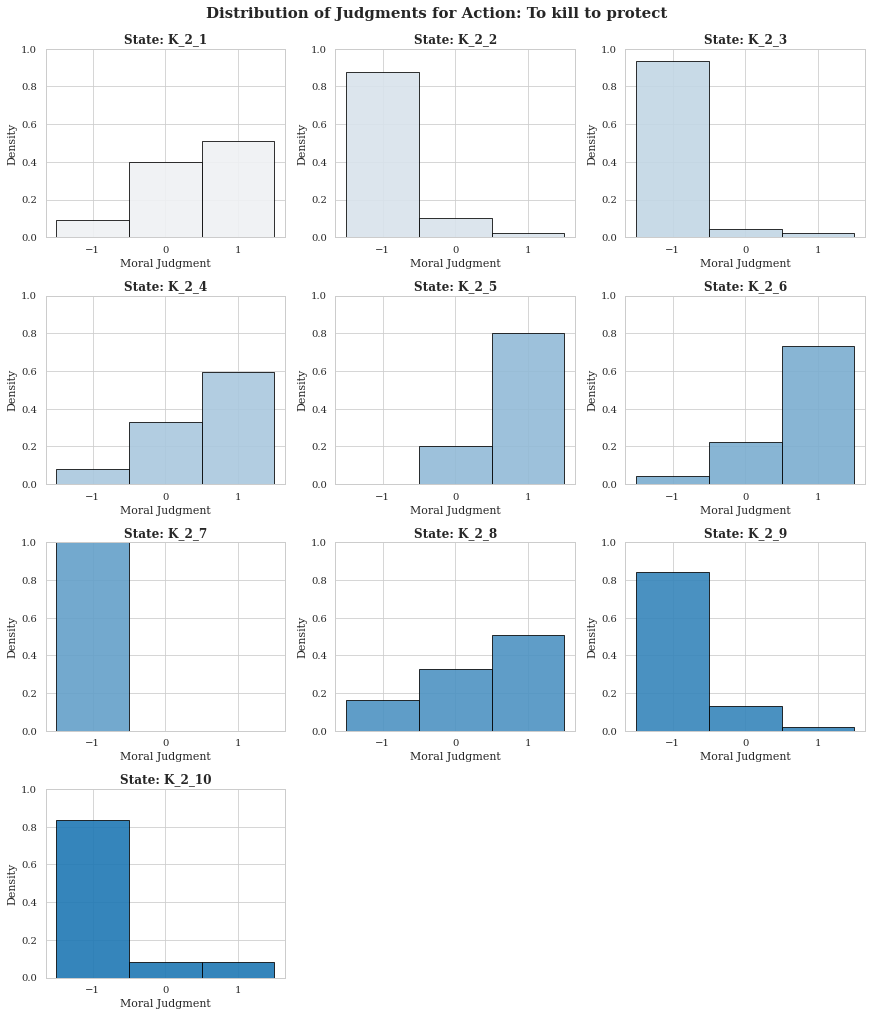

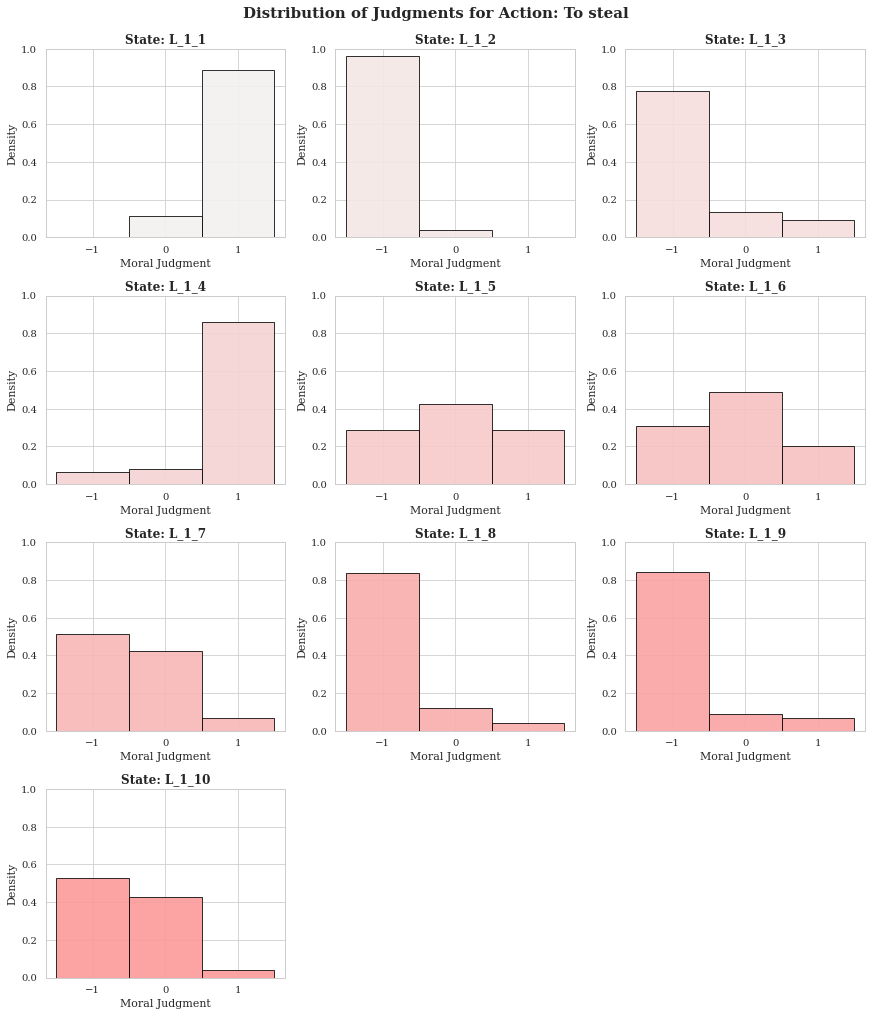

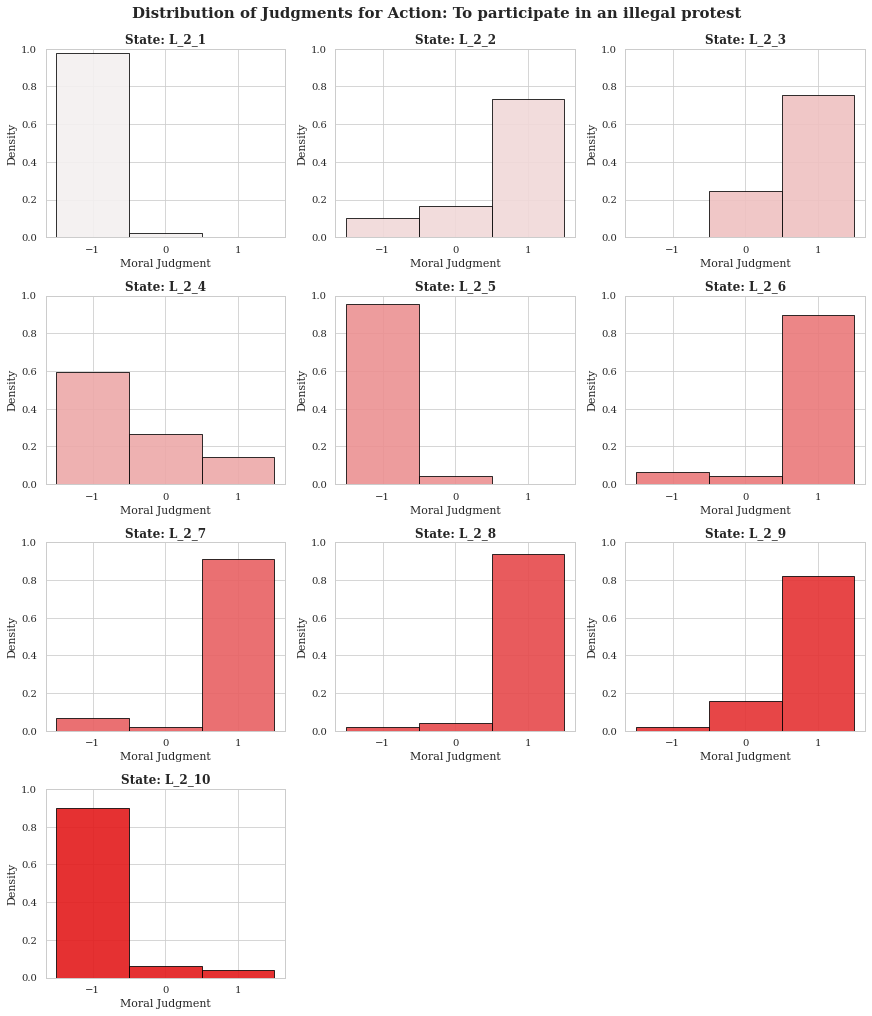

In [3]:
# Define a mapping to convert categorical moral judgments to numerical values
judgment_map = {
    'Support': 1,
    'Neutral': 0,
    'Blame': -1
}

# Initialize an empty list to store processed data dictionaries
modified_result_list = []

# Group the filtered DataFrame by question_ID and process each group
for _id, group in df2.groupby('question_ID'):
    # Extract the action code from the first 3 characters of question_ID
    action = _id[:3]
    
    # Map 'Moral Judgment' text to numerical values using the defined mapping
    reward = group['Moral Judgment'].map(judgment_map).tolist()
    
    # The state corresponds to the full question_ID
    states = _id
    
    # Create a dictionary for each question with action, reward list, and state
    result_dict = {'Action': action, 'Reward': reward, 'State': states}
    
    # Append this dictionary to the list
    modified_result_list.append(result_dict)

# A dictionary to translate action codes into descriptive action names
action_dict = {
    'K_1': 'To perform euthanasia',
    'K_2': 'To kill to protect',
    'D_1': 'To lie to support',
    'D_2': 'To lie by interest',
    'L_1': 'To steal',
    'L_2': 'To participate in an illegal protest'
}


# Set academic style for plots
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams["font.family"] = "serif"

# Define a base color palette for actions (from seaborn "Paired" palette)
palette = sns.color_palette("Paired", 6)
base_colors = {
    'K_1': palette[0],
    'K_2': palette[1],
    'D_1': palette[2],
    'D_2': palette[3],
    'L_1': palette[4],
    'L_2': palette[5]
}

# Convert the list of dictionaries into a proper DataFrame for plotting
rows = []
for entry in modified_result_list:
    action = entry["Action"]
    state = entry["State"]
    for reward in entry["Reward"]:
        rows.append({"Action": action, "State": state, "Reward": reward})

df_proper = pd.DataFrame(rows)

# Extract the unique actions for plotting
actions = df_proper["Action"].unique()

# Loop through each action to plot distributions of moral judgments by state
for action in actions:
    action_df = df_proper[df_proper["Action"] == action]
    states = natsorted(action_df["State"].unique())

    n_states = len(states)
    n_cols = min(3, n_states)  # max 3 columns per figure
    n_rows = (n_states + n_cols - 1) // n_cols

    # Create subplot grid with constrained layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows), constrained_layout=True)

    # Ensure axes is a flat array even if there is only one subplot
    if n_states == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()

    # Generate a light palette of colors based on the base color for this action
    base_color_name = base_colors.get(action, 'gray')
    palette = sns.light_palette(base_color_name, n_states, reverse=False)

    # Plot histograms of moral judgment distributions for each state
    for ax, state, color in zip(axes, states, palette):
        rewards = action_df[action_df["State"] == state]["Reward"]
        sns.histplot(
            rewards,
            bins=np.arange(-1.5, 2.5, 1),  # bins centered at -1, 0, 1
            ax=ax,
            color=color,
            edgecolor="black",
            alpha=0.9,
            kde=False,
            stat="density"
        )
        ax.set_title(f"State: {state}", fontsize=12, weight='semibold')
        ax.set_xlabel("Moral Judgment", fontsize=11)
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xticks([-1, 0, 1])
        ax.set_ylim(0, 1)
        ax.tick_params(axis='both', labelsize=10)

    # Hide any unused subplot axes
    for ax in axes[n_states:]:
        ax.axis("off")

    # Add a main title with the descriptive action name
    fig.suptitle(f"Distribution of Judgments for Action: {action_dict[action]}", fontsize=15, fontweight="bold")
    
    # Show the plot
    plt.show()

# Add an outcome if none 

In [4]:
def uniformisation(reward_distrib,n):
    if reward_distrib.count(1) == 0:
        reward_distrib.append(1)
        n+=1
    if reward_distrib.count(0)== 0:
        reward_distrib.append(0)
        n+=1
    if reward_distrib.count(-1)==0:
        reward_distrib.append(-1)
        n+=1
    return reward_distrib,n

modified_result_list_2 = []
n=0
for i in range(len(modified_result_list)):
    interm = {}
    interm['Action']=modified_result_list[i]['Action']
    double_output = uniformisation(modified_result_list[i]['Reward'],n)
    interm['Reward'],n = double_output[0],double_output[1]
    interm['State']= modified_result_list[i]['State']
    modified_result_list_2.append(interm)
print('Number of outcome modified (+1):', n)

Number of outcome modified (+1): 13


# Define the MBRL Agent 

In [15]:
import numpy as np

# Function to compute the Kullback-Leibler (KL) divergence
def DKL(d1, d2):
    """
    Compute the Kullback-Leibler (KL) divergence between two distributions.
    
    Arguments:
    - d1: First probability distribution (list or array)
    - d2: Second probability distribution (list or array)

    Returns:
    - KL divergence value
    """
    if not isinstance(d1, np.ndarray) and not isinstance(d2, np.ndarray):
        d1_array = np.array([d1[-1], d1[0], d1[1]])
        d2_array = np.array([d2[-1], d2[0], d2[1]])
        return np.sum(d1_array * np.log(d1_array / d2_array))
    
    elif isinstance(d1, np.ndarray) and not isinstance(d2, np.ndarray):
        d2_array = np.array([d2[-1], d2[0], d2[1]])
        return np.sum(d1 * np.log(d1 / d2_array))
    
    elif isinstance(d2, np.ndarray) and not isinstance(d1, np.ndarray):
        d1_array = np.array([d1[-1], d1[0], d1[1]])
        return np.sum(d1_array * np.log(d1_array / d2)) 
    
    else:
        return np.sum(d1 * np.log(d1 / d2))

# Function to compute the symmetrized Jensen-Shannon (JS) divergence
def swJS(d1, d2, N1, N2):
    """
    Compute the symmetrized Jensen-Shannon divergence between two distributions.

    Arguments:
    - d1: First probability distribution
    - d2: Second probability distribution
    - N1: Weight of the first distribution
    - N2: Weight of the second distribution

    Returns:
    - Symmetrized JS divergence value
    """
    d1_array = np.array([d1[-1], d1[0], d1[1]])
    d2_array = np.array([d2[-1], d2[0], d2[1]])
    
    # Compute the mixture distribution
    mix = (N1 * d1_array + N2 * d2_array) / (N1 + N2)
    
    return 0.5 * DKL(d1_array, mix) + 0.5 * DKL(d2_array, mix)

# Function to estimate a probability distribution from a sample
def distribution(samples):
    """
    Compute a probability distribution from a list of samples.

    Arguments:
    - samples: List of observed values (-1, 0, or 1)

    Returns:
    - Normalized probability distribution dictionary
    """
    unique, counts = np.unique(samples, return_counts=True)
    total = len(samples)

    # Compute probabilities
    dist = {val: count / total for val, count in zip(unique, counts)}

    # Ensure all possible values (-1, 0, 1) have a minimum probability
    for val in [-1, 0, 1]:
        if val not in dist:
            dist[val] = 1e-5

    # Normalize probabilities
    total_prob = sum(dist.values())
    dist = {key: value / total_prob for key, value in dist.items()}

    return dist


def del_of_a_list(L1,L2):
    for val in L2:
        if val in L1:
            L1.remove(val)



def MBRL_agent(dilemma_list, contexts_created, list_of_actions, adding_threshold, merging_threshold):
    """
    Main function to run the MBRL agent.

    Arguments:
    - dilemma_list: List of dilemmas to process
    - Contexts: Dictionary of contexts
    - list_of_actions: List of known actions
    - adding_threshold: Threshold for adding new contexts
    - merging_threshold: Threshold for merging contexts

    Returns:
    - Updated Contexts dictionary
    """
    
    
    for dilemma in dilemma_list:
        """
        Process a dilemma and update existing contexts or create a new one if necessary.

        Arguments:
        - dilemma: Dictionary containing 'Reward', 'Action', and 'State' values
        - Contexts: Dictionary of existing contexts
        - list_of_actions: List of actions considered
        - threshold: Threshold for KL divergence to determine new contexts
        """

        reward_distribution = distribution(dilemma['Reward'])  

        # Check if the action exists in the list
        if dilemma['Action'] in list_of_actions:
            context_list = list(contexts_created[dilemma['Action']].keys())
            DKL_context = []
            
            """
            Check if the state is already in memory in a context
            
            """
            
            for i in range(len(context_list)):
                for j in range(len(contexts_created[dilemma['Action']]['C'+str(i+1)]['States'])):
                    if dilemma['State'] == contexts_created[dilemma['Action']]['C'+str(i+1)]['States'][j][0]:
                        dilemma['Reward'].extend(contexts_created[dilemma['Action']]['C'+str(i+1)]['States'][j][1])
                        del_of_a_list(contexts_created[dilemma['Action']]['C'+str(i+1)]['Outcomes'],contexts_created[dilemma['Action']]['C'+str(i+1)]['States'][j][1])
                        del contexts_created[dilemma['Action']]['C'+str(i+1)]['States'][j]
                        contexts_created[dilemma['Action']]['C'+str(i+1)]['Distribution'] = distribution(
                            contexts_created[dilemma['Action']]['C'+str(i+1)]['Outcomes'])

                
                
                
            # Compute KL divergence for each context
            for i in range(len(context_list)):
                DKL_context.append(DKL(reward_distribution, contexts_created[dilemma['Action']]['C'+str(i+1)]['Distribution']))

            min_dkl, context_min_dkl = np.min(DKL_context), np.argmin(DKL_context)

            if min_dkl > adding_threshold:
                # Create a new context if KL divergence exceeds the threshold
                contexts_created[dilemma['Action']]['C'+str(1+len(contexts_created[dilemma['Action']]))] = {
                    'Distribution': reward_distribution,
                    'Outcomes': dilemma['Reward'],
                    'States': [[dilemma['State'], dilemma['Reward']]],
                }
            else:
                # Update existing context
                contexts_created[dilemma['Action']]['C'+str(context_min_dkl+1)]['Outcomes'] = np.concatenate(
                    (contexts_created[dilemma['Action']]['C'+str(context_min_dkl+1)]['Outcomes'], dilemma['Reward']))
                contexts_created[dilemma['Action']]['C'+str(context_min_dkl+1)]['States'].append([dilemma['State'], dilemma['Reward']])
                contexts_created[dilemma['Action']]['C'+str(context_min_dkl+1)]['Distribution'] = distribution(
                    contexts_created[dilemma['Action']]['C'+str(context_min_dkl+1)]['Outcomes'])

        else:
            # If action is new, add it and create a new context
            list_of_actions.append(dilemma['Action'])
            contexts_created[dilemma['Action']] = {
                'C1': {
                    'Distribution': reward_distribution,
                    'Outcomes': dilemma['Reward'],
                    'States': [[dilemma['State'], dilemma['Reward']]],
                }
            }



        """
        Merge similar contexts based on JS divergence.

        Arguments:
        - Contexts: Dictionary of contexts
        - threshold: Merging threshold
        """
        action_list = list(contexts_created.keys())

        for action in action_list:
            swJS_list = [[], []]

            if len(contexts_created[action]) > 1:
                for i in range(len(contexts_created[action])):
                    for j in range(i+1, len(contexts_created[action])):
                        swJS_list[0].append([i, j])
                        swJS_list[1].append(
                            swJS(contexts_created[action]['C'+str(i+1)]['Distribution'],
                                 contexts_created[action]['C'+str(j+1)]['Distribution'],
                                 len(contexts_created[action]['C'+str(i+1)]['Outcomes']),
                                 len(contexts_created[action]['C'+str(j+1)]['Outcomes']))
                        )

                min_swJS, context_min_swJS = np.min(swJS_list[1]), np.argmin(swJS_list[1])
    
                if min_swJS < merging_threshold:
                    i, j = swJS_list[0][context_min_swJS]
                    n = len(contexts_created[action])
                    contexts_created[action]['C'+str(i+1)]['Outcomes'] = list(contexts_created[action]['C'+str(i+1)]['Outcomes'])
                    contexts_created[action]['C'+str(j+1)]['Outcomes'] = list(contexts_created[action]['C'+str(j+1)]['Outcomes'])
                    contexts_created[action]['C'+str(i+1)]['States'] = list(contexts_created[action]['C'+str(i+1)]['States'])
                    contexts_created[action]['C'+str(j+1)]['States'] = list(contexts_created[action]['C'+str(j+1)]['States'])
                    
                    
                    # Merge contexts
                    contexts_created[action]['C'+str(i+1)]['Outcomes'] += contexts_created[action]['C'+str(j+1)]['Outcomes']
                    contexts_created[action]['C'+str(i+1)]['States'] += contexts_created[action]['C'+str(j+1)]['States']
                    contexts_created[action]['C'+str(i+1)]['Distribution'] = distribution(contexts_created[action]['C'+str(i+1)]['Outcomes'])

                    # Replace merged context with the last context
                    contexts_created[action]['C'+str(j+1)] = contexts_created[action]['C'+str(n)]
                    del contexts_created[action]['C'+str(n)]
        
    return contexts_created

# Contexts created by the MBRL Agent 

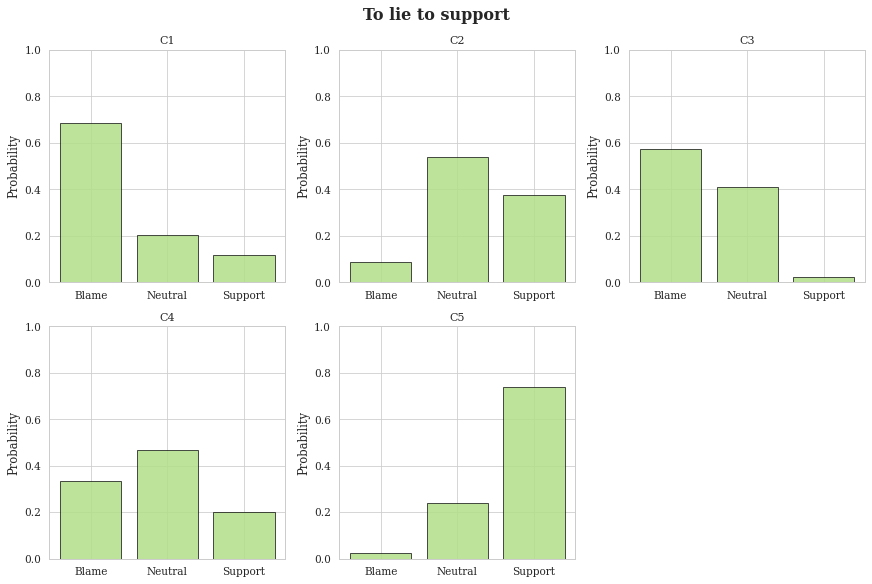

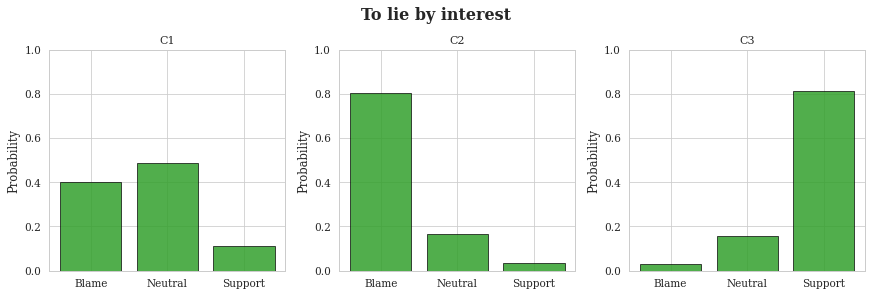

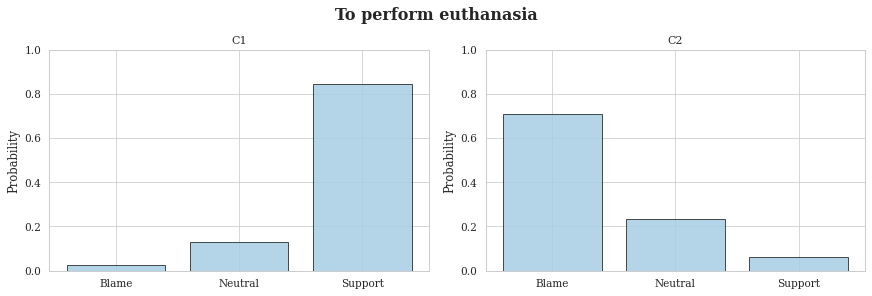

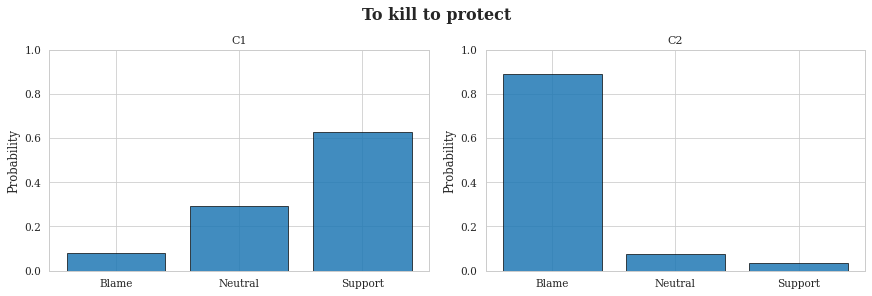

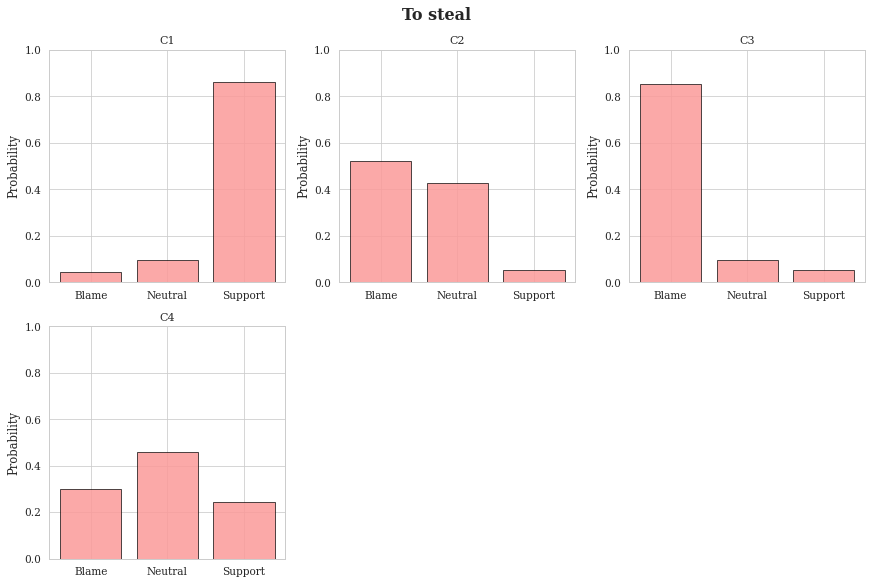

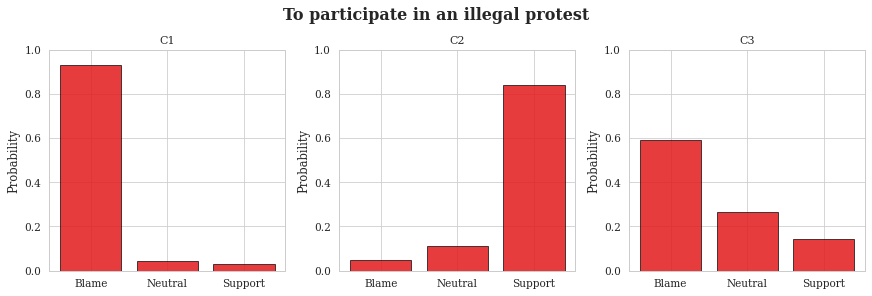

In [6]:
classification = {}
list_of_actions = []
classification = MBRL_agent(modified_result_list_2, classification, list_of_actions, 0.12, 0.03)

# Mapping action → couleur de base (noms de couleurs Seaborn/matplotlib)
palette = sns.color_palette("Paired", 6)
base_colors = {
    'K_1': palette[0],
    'K_2': palette[1],
    'D_1': palette[2],
    'D_2': palette[3],
    'L_1': palette[4],
    'L_2': palette[5]
}

# Iterate over actions
for action, contexts in classification.items():
    context_keys = list(contexts.keys())
    n_contexts = len(context_keys)

    # Set up grid (max 3 columns)
    n_cols = min(3, n_contexts)
    n_rows = (n_contexts + n_cols - 1) // n_cols  

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), constrained_layout=True)
    axes = np.array(axes).flatten()

    # Palette plus élégante (ex : cubehelix doux)
    palette = sns.color_palette("ch:s=.25,rot=-.25", n_colors=n_contexts)

    for ax, context, color in zip(axes, context_keys, palette):
        distribution = contexts[context]['Distribution']

        x_values = [-1, 0, 1]
        y_values = [distribution.get(x, 0) for x in x_values]

        # Change x-axis labels to more intuitive labels
        ax.bar(x_values, y_values, color=base_colors[action], edgecolor="black", alpha=0.85)
        ax.set_title(f"{context}", fontsize=11)
        #ax.set_xlabel("Reward")
        ax.set_ylabel("Probability")
        ax.set_xticks([-1, 0, 1])
        ax.set_xticklabels(["Blame", "Neutral", "Support"])  # Custom labels
        ax.set_ylim(0, 1)

    # Hide unused subplots
    for ax in axes[n_contexts:]:
        ax.axis("off")

    # Main title for the figure
    fig.suptitle(f"{action_dict[action]}", fontsize=16, fontweight="bold")
    
    # Show the plot
    plt.show()

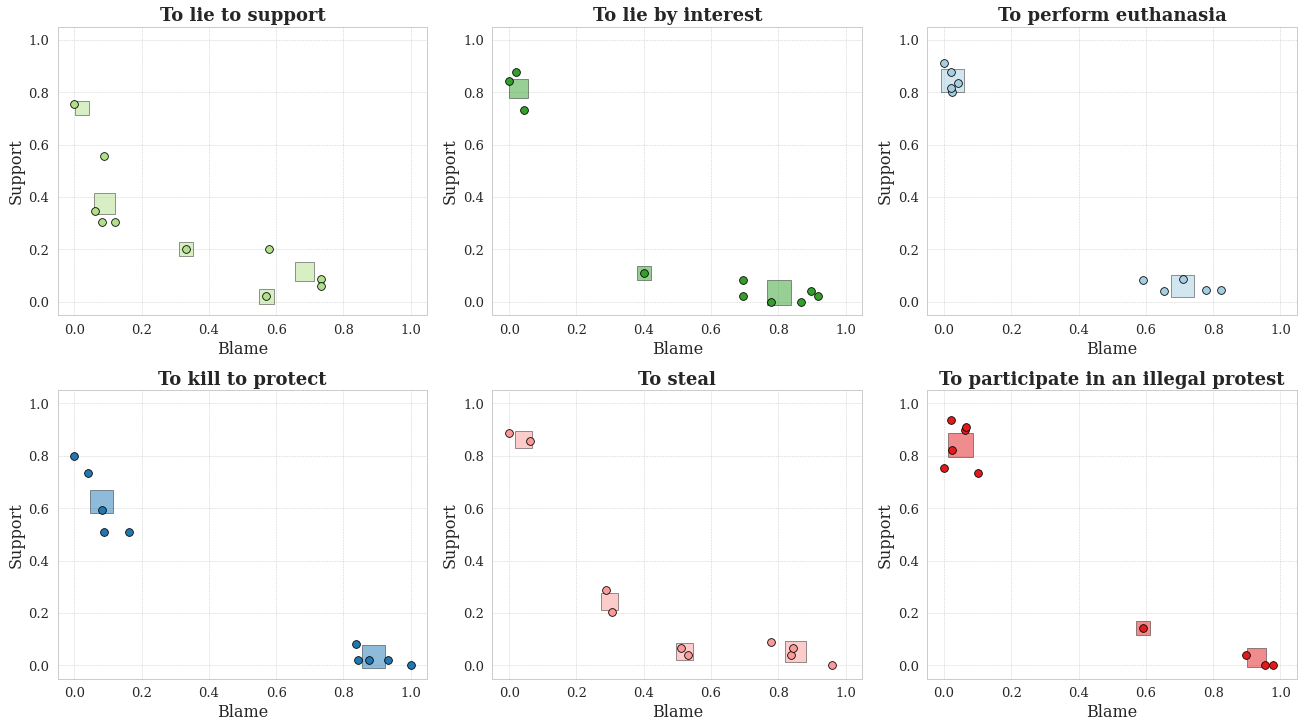

In [10]:
def compute_distribution(lst):
    c = Counter(lst)
    total = sum(c.values())
    return {k: v / total for k, v in c.items()}

plt.rcParams.update({
    'font.size': 14,         # taille générale du texte
    'axes.titlesize': 18,    # titres des sous-graphes
    'axes.labelsize': 16,    # étiquettes des axes
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 14,
    'figure.titlesize': 20   # titre global
})


# Palette contrastée
palette = sns.color_palette("Paired", 6)
base_colors = {
    'K_1': palette[0],
    'K_2': palette[1],
    'D_1': palette[2],
    'D_2': palette[3],
    'L_1': palette[4],
    'L_2': palette[5]
}

# États (df_proper → points)
state_points = []
for action in df_proper["Action"].unique():
    action_df = df_proper[df_proper["Action"] == action]
    states = natsorted(action_df["State"].unique())
    for state in states:
        rewards = action_df[action_df["State"] == state]["Reward"].tolist()
        dist = compute_distribution(rewards)
        state_points.append({
            'Blame': dist.get(-1, 0),
            'Support': dist.get(1, 0),
            'Action': action,
            'State': state,
            'Color': base_colors.get(action, 'gray')
        })
df_states = pd.DataFrame(state_points)

# Clusters (classification → points)
cluster_points = []
for action, contexts in classification.items():
    for context_name, context_data in contexts.items():
        dist = context_data["Distribution"]
        num_states = len(context_data.get("States", []))
        cluster_points.append({
            'Blame': dist.get(-1, 0),
            'Support': dist.get(1, 0),
            'Action': action,
            'Context': context_name,
            'Color': base_colors.get(action, 'gray'),
            'Size': 120 + 80 * num_states 
        })
df_clusters = pd.DataFrame(cluster_points)

# Set up subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10), constrained_layout=True)
axes = axes.flatten()

# Plot for each action
for i, action in enumerate(sorted(df_states["Action"].unique())):
    ax = axes[i]
    color = base_colors.get(action, 'gray')
    label = action_dict.get(action, action)
    
    # Clusters
    subset_clusters = df_clusters[df_clusters["Action"] == action]
    ax.scatter(
        subset_clusters["Blame"],
        subset_clusters["Support"],
        s=subset_clusters["Size"],
        color=color,
        alpha=0.5,
        edgecolors="black",
        marker='s',
        label="Clusters"
    )

    # États
    subset_states = df_states[df_states["Action"] == action]
    ax.scatter(
        subset_states["Blame"],
        subset_states["Support"],
        s=60,
        color=color,
        alpha=1,
        edgecolors="black",
        label="States"
    )



    ax.set_title(f"{label}", fontsize=18, fontweight="bold")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Blame", fontsize=16)
    ax.set_ylabel("Support", fontsize=16)
    ax.grid(True, linestyle="--", linewidth=0.5)

# Remove empty axes if fewer than 6 actions
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global legend
handles, labels = axes[0].get_legend_handles_labels()

plt.show()


# Contexts evolution action by action

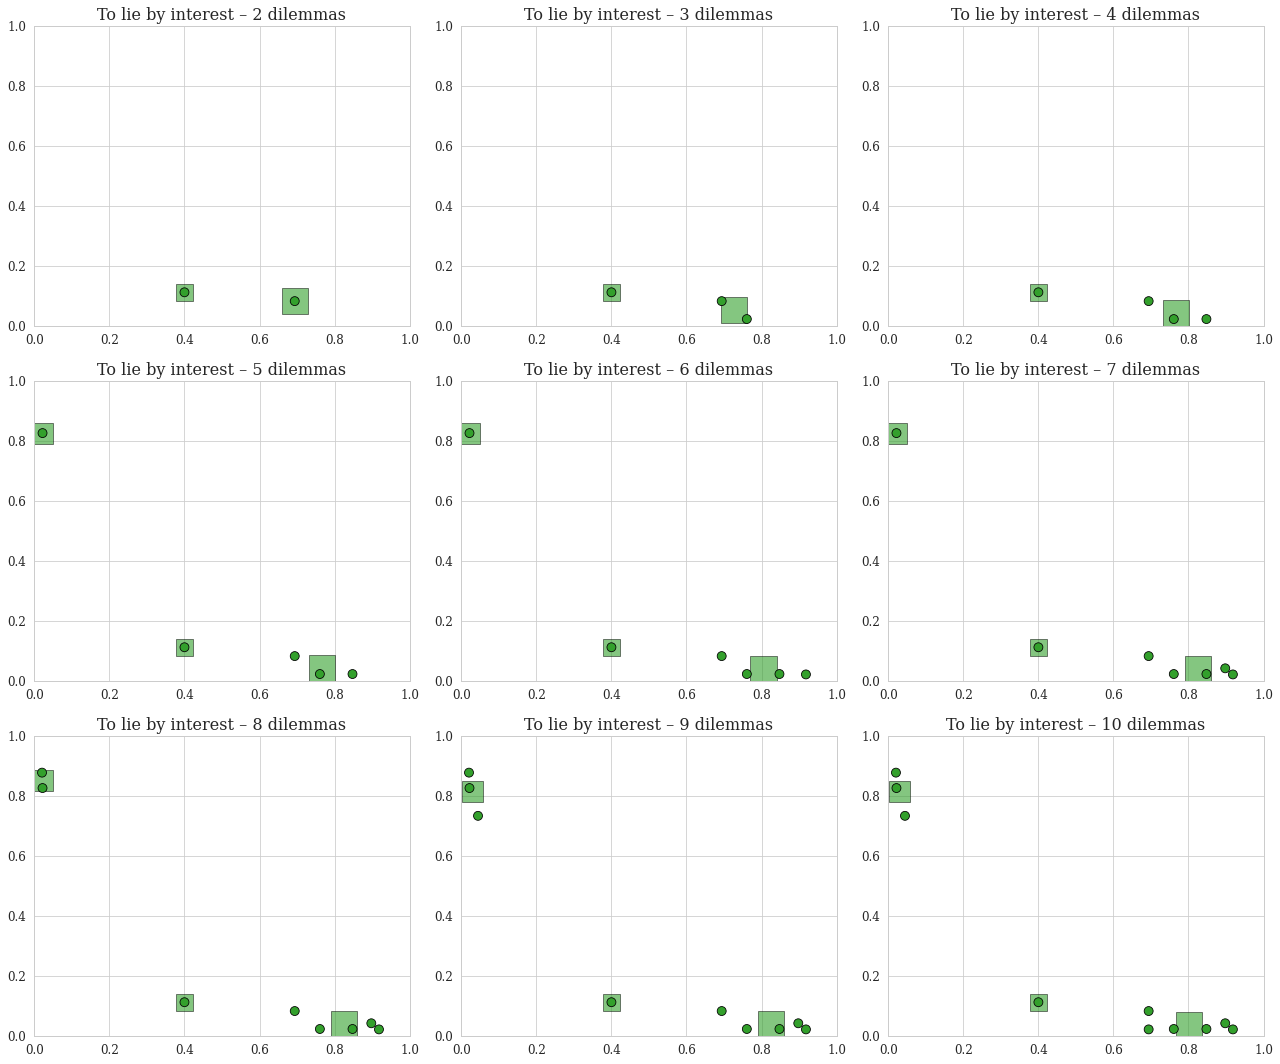

In [33]:
# MBRL_agent_3 simulates a model-based RL agent that incrementally clusters contexts
# based on state-reward distributions for each action. It tracks the evolution of
# context formation and optionally saves snapshots at each step.

def MBRL_agent_3(dilemma_list, contexts_created, list_of_actions, adding_threshold, merging_threshold, save_steps=False):
    snapshots = []  # Stores the encountered dilemmas at each step (for visualization)
    dilemmas_encount = []  # Running list of encountered dilemmas
    classification_snapshots = []  # Stores deep copies of the classification state

    for dilemma in dilemma_list:
        dilemmas_encount.append(dilemma)
        reward_distribution = distribution(dilemma['Reward'])  # Compute reward distribution for current state

        if dilemma['Action'] in list_of_actions:
            context_list = list(contexts_created[dilemma['Action']].keys())

            # Check if this exact state has already been seen (and stored in a cluster)
            for i in range(len(context_list)):
                for j, (state, rewards) in enumerate(contexts_created[dilemma['Action']][f'C{i+1}']['States']):
                    if dilemma['State'] == state:
                        # If found, update its reward list and remove old rewards from context
                        dilemma['Reward'].extend(rewards)
                        del_of_a_list(contexts_created[dilemma['Action']][f'C{i+1}']['Outcomes'], rewards)
                        del contexts_created[dilemma['Action']][f'C{i+1}']['States'][j]
                        # Update distribution after removing old data
                        contexts_created[dilemma['Action']][f'C{i+1}']['Distribution'] = distribution(
                            contexts_created[dilemma['Action']][f'C{i+1}']['Outcomes'])

            # Compute KL divergence between this state and all existing clusters
            DKL_context = []
            for i in range(len(context_list)):
                DKL_context.append(DKL(
                    reward_distribution,
                    contexts_created[dilemma['Action']][f'C{i+1}']['Distribution']
                ))

            # Find cluster with minimum KL divergence
            min_dkl, context_min_dkl = np.min(DKL_context), np.argmin(DKL_context)

            # If divergence too high, create a new context cluster
            if min_dkl > adding_threshold:
                contexts_created[dilemma['Action']][f'C{len(contexts_created[dilemma["Action"]]) + 1}'] = {
                    'Distribution': reward_distribution,
                    'Outcomes': dilemma['Reward'],
                    'States': [[dilemma['State'], dilemma['Reward']]],
                }
            else:
                # Otherwise, assign to closest cluster and update its stats
                selected = contexts_created[dilemma['Action']][f'C{context_min_dkl + 1}']
                selected['Outcomes'] = np.concatenate((selected['Outcomes'], dilemma['Reward']))
                selected['States'].append([dilemma['State'], dilemma['Reward']])
                selected['Distribution'] = distribution(selected['Outcomes'])

        else:
            # First time this action is seen: create its first context
            list_of_actions.append(dilemma['Action'])
            contexts_created[dilemma['Action']] = {
                'C1': {
                    'Distribution': reward_distribution,
                    'Outcomes': dilemma['Reward'],
                    'States': [[dilemma['State'], dilemma['Reward']]],
                }
            }

        # Attempt to merge similar contexts within each action
        for action in list(contexts_created.keys()):
            swJS_list = [[], []]  # Stores (i, j) index pairs and their swJS scores
            keys = list(contexts_created[action].keys())

            if len(keys) > 1:
                # Compute swJS divergence between all context pairs
                for i in range(len(keys)):
                    for j in range(i+1, len(keys)):
                        swJS_list[0].append([i, j])
                        swJS_list[1].append(
                            swJS(
                                contexts_created[action][f'C{i+1}']['Distribution'],
                                contexts_created[action][f'C{j+1}']['Distribution'],
                                len(contexts_created[action][f'C{i+1}']['Outcomes']),
                                len(contexts_created[action][f'C{j+1}']['Outcomes'])
                            )
                        )

                # Find the pair with smallest swJS divergence
                min_swJS, context_min_swJS = np.min(swJS_list[1]), np.argmin(swJS_list[1])

                # If below threshold, merge the two contexts
                if min_swJS < merging_threshold:
                    i, j = swJS_list[0][context_min_swJS]
                    n = len(contexts_created[action])

                    # Prepare both clusters for merging (convert outcomes to list)
                    contexts_created[action][f'C{i+1}']['Outcomes'] = list(contexts_created[action][f'C{i+1}']['Outcomes'])
                    contexts_created[action][f'C{j+1}']['Outcomes'] = list(contexts_created[action][f'C{j+1}']['Outcomes'])

                    # Merge j into i
                    contexts_created[action][f'C{i+1}']['States'] += contexts_created[action][f'C{j+1}']['States']
                    contexts_created[action][f'C{i+1}']['Outcomes'] += contexts_created[action][f'C{j+1}']['Outcomes']
                    contexts_created[action][f'C{i+1}']['Distribution'] = distribution(contexts_created[action][f'C{i+1}']['Outcomes'])

                    # Replace j-th with last context and delete last
                    contexts_created[action][f'C{j+1}'] = contexts_created[action][f'C{n}']
                    del contexts_created[action][f'C{n}']

        # Save a snapshot of current state if requested
        if save_steps:
            snapshots.append(dilemmas_encount.copy())
            classification_snapshot = {a: {k: v.copy() for k, v in contexts_created[a].items()} for a in contexts_created}
            classification_snapshots.append(classification_snapshot)

    if save_steps:
        return contexts_created, snapshots, classification_snapshots
    else:
        return contexts_created


# This function visualizes the evolution of clusters (contexts) for a given action
# across saved classification snapshots. Each subplot shows the state and cluster
# distributions at a particular step of training.

def plot_2(snapshots, classification_snapshots, action_name, i):
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    palette = sns.color_palette("Paired", 6)
    base_colors = {'K_1': palette[0], 'K_2': palette[1], 'D_1': palette[2],
                   'D_2': palette[3], 'L_1': palette[4], 'L_2': palette[5]}

    fig, axs = plt.subplots(3, 3, figsize=(18, 15))
    axs = axs.flatten()

    for plot_idx, idx in enumerate(range(1, 10)):  # plot steps 2 to 10
        if idx >= len(snapshots) or idx >= len(classification_snapshots):
            continue

        dilemmas_encountered = snapshots[idx]

        # Extract all rewards for this action at this step
        rows = [
            {
                "Action": entry['Action'],
                "State": entry['State'],
                "Reward": reward
            }
            for entry in dilemmas_encountered if entry['Action'] == action_name
            for reward in entry['Reward']
        ]

        df_proper_func = pd.DataFrame(rows)

        # Extract cluster centers for current action at this step
        cluster_points = []
        if action_name in classification_snapshots[idx]:
            for context_name, context_data in classification_snapshots[idx][action_name].items():
                dist = context_data["Distribution"]
                num_states = len(context_data.get("States", []))
                x = dist.get(-1, 0)
                y = dist.get(1, 0)
                cluster_points.append({
                    "x": x,
                    "y": y,
                    "Color": base_colors.get(action_name, "gray"),
                    "Size": 200 + 80 * num_states
                })
        df_clusters = pd.DataFrame(cluster_points)

        # Compute distribution of individual states
        state_points = []


        states = natsorted(df_proper_func["State"].unique())
        for state in states:
            rewards = df_proper_func[df_proper_func["State"] == state]["Reward"].tolist()
            dist = compute_distribution(rewards)
            x = dist.get(-1, 0)
            y = dist.get(1, 0)
            state_points.append({
                'x': x,
                'y': y,
                'Color': base_colors.get(action_name, 'gray'),
            })
        df_states = pd.DataFrame(state_points)

        # Plot cluster centroids (squares) and states (circles)
        ax = axs[plot_idx]
        if not df_clusters.empty:
            ax.scatter(df_clusters["x"], df_clusters["y"],
                       color=df_clusters["Color"], s=df_clusters["Size"],
                       alpha=0.6, edgecolors="black", marker='s')
        if not df_states.empty:
            ax.scatter(df_states["x"], df_states["y"],
                       color=df_states["Color"], s=80,
                       alpha=1, edgecolors="black")

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f"{action_dict.get(action_name, action_name)} – {idx+1} dilemmas")
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(f"Evolution_{action_name}" + str(i) + ".pdf")
    plt.show()


# Run the clustering and visualization for two datasets
actions = ['K_1', 'K_2', 'L_1', 'L_2', 'D_1', 'D_2']
for i in range(10):
    dilemmas_action_only = [d for d in modified_result_list_2 if d['Action'] == 'D_2']
    classification = {}
    list_of_actions = []
    random.shuffle(dilemmas_action_only)
    if i == 0 : 
        classification, snapshots, classification_snapshots = MBRL_agent_3(
            dilemmas_action_only, classification, list_of_actions,
            adding_threshold=0.12, merging_threshold=0.03, save_steps=True
        )
    else : 
        classification, snapshots, classification_snapshots = MBRL_agent_3(
            dilemmas_action_only, classification, list_of_actions,
            adding_threshold=0.12, merging_threshold=0.03, save_steps=True
        )

plot_2(snapshots, classification_snapshots, 'D_2', i)
